# Load data

In [1]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import scanpy as sc

In [2]:
dataset_meta = 'pbmc_1k_v3'
bcs_filtered_loc = f'/home/ggorin/count_data/{dataset_meta}/counts_filtered/spliced.barcodes.txt'
data_raw_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/adata.loom'
raw_data = sc.read_loom(data_raw_loc)

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
bcs_filtered = pd.read_csv(bcs_filtered_loc,header=None)
filtered_idx = raw_data.obs['barcode'].isin(np.asarray(bcs_filtered).squeeze())
background_data = raw_data[~filtered_idx]
background_data.write_loom('data/pbmc_1k_v3_empty.loom')

In [4]:
adata = raw_data[filtered_idx]

# Filtered droplets

In [5]:
data = adata.layers[spliced_layer].toarray()
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

0.4738271971435195


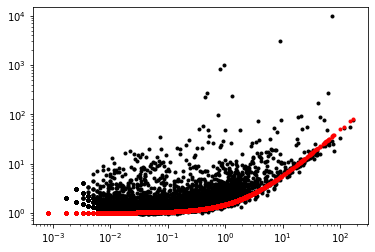

In [6]:
mean = X.mean(axis=0)
var = X.var(axis=0)
plt.loglog(mean, var/mean,'k.');
plt.loglog(mean, 1+s*mean,'r.');

# Background data

In [7]:
data = background_data.layers[spliced_layer].toarray()
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

2.3518886503831204


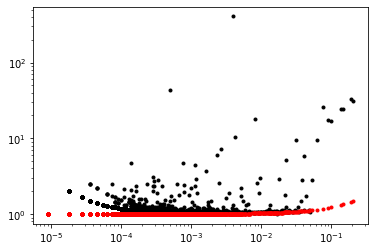

In [8]:
mean = X.mean(axis=0)
var = X.var(axis=0)
plt.loglog(mean, var/mean,'k.');
plt.loglog(mean, 1+s*mean,'r.');

## Check total counts

In [9]:
empty_droplets = raw_data.layers[spliced_layer][~filtered_idx,:].toarray()
total_counts = np.sum(empty_droplets,axis=1)
print(total_counts.max())
print(total_counts.mean(),total_counts.var())

908.0
5.509911 275.34988


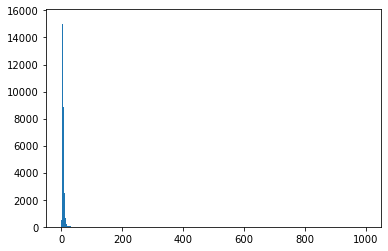

In [10]:
res = plt.hist(total_counts,bins=np.arange(0,1000,1)-0.5);
epmf = res[0]

**The distribution of total counts of "empty" droplets has a long tail**

## Possionion regime

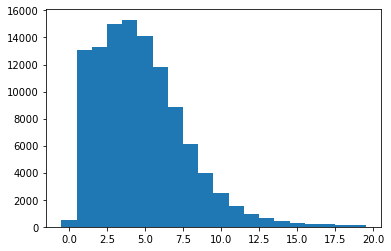

In [11]:
res = plt.hist(total_counts,bins=np.arange(0,21,1)-0.5)
epmf_20 = res[0]

In [12]:
#lam = np.arange(0,20).reshape((1,-1))@epmf.reshape((-1,1))/epmf_20.sum()
#lam = lam[0][0]
lam = total_counts.mean()

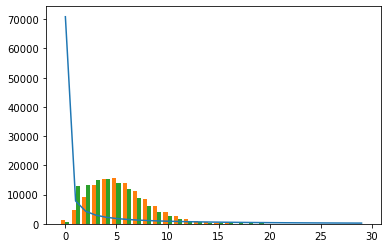

In [13]:
from scipy.stats import poisson, nbinom

sigma2 = total_counts.var() #lam + s*lam**2
p = lam/sigma2
n = lam**2/(sigma2-lam)
prob = nbinom.pmf(np.arange(30), n, p)

c=0.5
x = np.random.poisson(c*np.random.poisson(lam/c,size=110031))

plt.plot(np.arange(30),prob*110031)
plt.hist([x,total_counts],bins=np.arange(0,31,1)-0.5);

In [14]:
print((x>20).sum(),(total_counts>20).sum())

5 967


## Power law regime

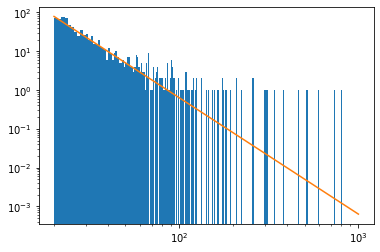

In [15]:
plt.hist(total_counts,bins=np.arange(20,1000,1));
plt.xscale('log')
plt.yscale('log')
plt.plot(np.arange(20,1000,1),10**5.8*np.arange(20.0,1000,1)**-3);

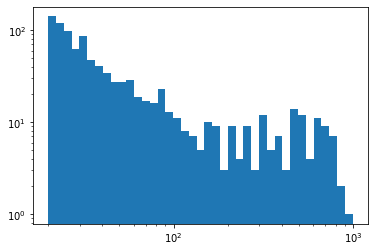

In [16]:
plt.hist(total_counts,bins=np.exp(np.arange(3,7,0.1)));
plt.xscale('log')
plt.yscale('log')
#plt.plot(np.arange(20,1000,1),10**5.8*np.arange(20.0,1000,1)**-3);

In [17]:
from scipy.stats import zipf

#pmf_z = zipf.pmf(k=np.arange(0,999,1), a=3)
z = zipf.rvs(a=2.5,size=110000)

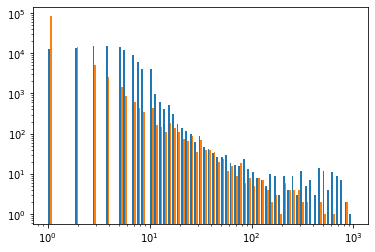

In [18]:
x_=np.exp(np.arange(0,7,0.1))
plt.hist([total_counts,z],bins=x_);
plt.xscale('log')
plt.yscale('log')

## Are abundances different?

In [19]:
filled = empty_droplets[total_counts>20]
empty = empty_droplets[(total_counts<=20)&(total_counts>0)]

In [20]:
filled.mean()/empty.mean()

19.061483

In [21]:
filled_mean = (filled/filled.sum(axis=1,keepdims=True)).mean(axis=0)
empty_mean = (empty/empty.sum(axis=1,keepdims=True)).mean(axis=0)

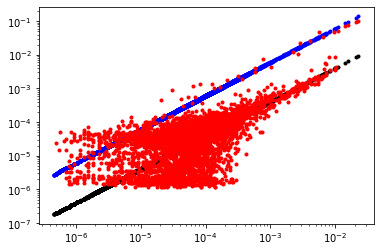

In [29]:
plt.loglog(empty_mean, 0.4*empty_mean,'k.');
plt.loglog(empty_mean, 6*empty_mean,'b.');
plt.loglog(empty_mean, filled_mean,'r.');

(0.0, 0.01)

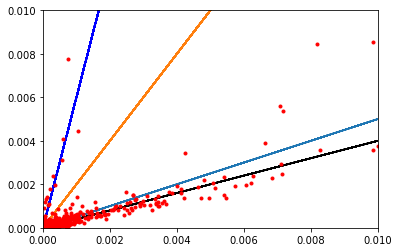

In [36]:
plt.plot(empty_mean, 0.4*empty_mean,'k-');
plt.plot(empty_mean, 0.5*empty_mean,'-');
plt.plot(empty_mean, 2*empty_mean,'-');
plt.plot(empty_mean, 6*empty_mean,'b-');
plt.plot(empty_mean, filled_mean,'r.');
plt.xlim((0,0.01))
plt.ylim((0,0.01))

# Find outlier genes

In [43]:
outlier_gene_idx = (filled_mean > 2*empty_mean) & (filled_mean > 1e-3)
print(outlier_gene_idx.sum())
background_data.var_names[outlier_gene_idx]

24


Index(['2987', '5167', '6618', '15197', '23227', '23286', '25365', '25932',
       '25933', '32270', '35329', '35330', '35331', '35332', '35333', '35334',
       '35335', '35336', '35337', '35338', '35339', '35340', '35341', '36332'],
      dtype='object')

In [40]:
gene_names = pd.read_csv(f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/spliced.genes.txt',header=None)

In [50]:
outlier_genes = gene_names[outlier_gene_idx]
outlier_genes[0].tolist()

['ENSG00000270188.1',
 'ENSG00000154146.13',
 'ENSG00000255823.5',
 'ENSG00000256618.2',
 'ENSG00000203618.5',
 'ENSG00000211679.2',
 'ENSG00000269028.3',
 'ENSG00000163736.4',
 'ENSG00000163737.4',
 'ENSG00000270672.1',
 'ENSG00000198840.2',
 'ENSG00000212907.2',
 'ENSG00000198886.2',
 'ENSG00000198888.2',
 'ENSG00000198763.3',
 'ENSG00000198786.2',
 'ENSG00000198804.2',
 'ENSG00000198695.2',
 'ENSG00000198712.1',
 'ENSG00000198727.2',
 'ENSG00000228253.1',
 'ENSG00000198899.2',
 'ENSG00000198938.2',
 'ENSG00000256045.3']

Tue Feb 21 22:49:59 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Feb 21 22:49:59 2023 INFO Getting gene symbols from Ensembl IDs.
Tue Feb 21 22:50:01 2023 WARNING ID 'ENSG00000270188' not found. Please double-check spelling/arguments.
Tue Feb 21 22:50:03 2023 WARNING ID 'ENSG00000255823' not found. Please double-check spelling/arguments.
Tue Feb 21 22:50:04 2023 WARNING ID 'ENSG00000256618' not found. Please double-check spelling/arguments.
Tue Feb 21 22:50:07 2023 WARNING ID 'ENSG00000269028' not found. Please double-check spelling/arguments.
Tue Feb 21 22:50:10 2023 WARNING ID 'ENSG00000270672' not found. Please double-check spelling/arguments.
Tue Feb 21 22:50:20 2023 WARNING ID 'ENSG00000256045' not found. Please double-check spelling/arguments.
Tue Feb 21 22:50:2

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,chemokine-mediated signaling pathway (GO:0070098),0.001145,46.129630,312.418122,"[PPBP, PF4]",0.020074,GO_Biological_Process_2021
1,2,cellular response to chemokine (GO:1990869),0.001313,42.939655,284.928034,"[PPBP, PF4]",0.020074,GO_Biological_Process_2021
2,3,antimicrobial humoral immune response mediated...,0.001492,40.161290,261.351172,"[PPBP, PF4]",0.020074,GO_Biological_Process_2021
3,4,neutrophil chemotaxis (GO:0030593),0.001782,36.606618,231.725354,"[PPBP, PF4]",0.020074,GO_Biological_Process_2021
4,5,granulocyte chemotaxis (GO:0071621),0.001936,35.054577,218.993737,"[PPBP, PF4]",0.020074,GO_Biological_Process_2021
5,6,neutrophil migration (GO:1990266),0.002151,33.178333,203.779265,"[PPBP, PF4]",0.020074,GO_Biological_Process_2021
6,7,cellular response to molecule of bacterial ori...,0.004722,21.978982,117.709743,"[PPBP, PF4]",0.034552,GO_Biological_Process_2021
7,8,cellular response to lipopolysaccharide (GO:00...,0.005130,21.042373,110.950806,"[PPBP, PF4]",0.034552,GO_Biological_Process_2021
8,9,platelet degranulation (GO:0002576),0.005553,20.181911,104.812939,"[PPBP, PF4]",0.034552,GO_Biological_Process_2021
9,10,response to lipopolysaccharide (GO:0032496),0.008839,15.784236,74.636821,"[PPBP, PF4]",0.045937,GO_Biological_Process_2021


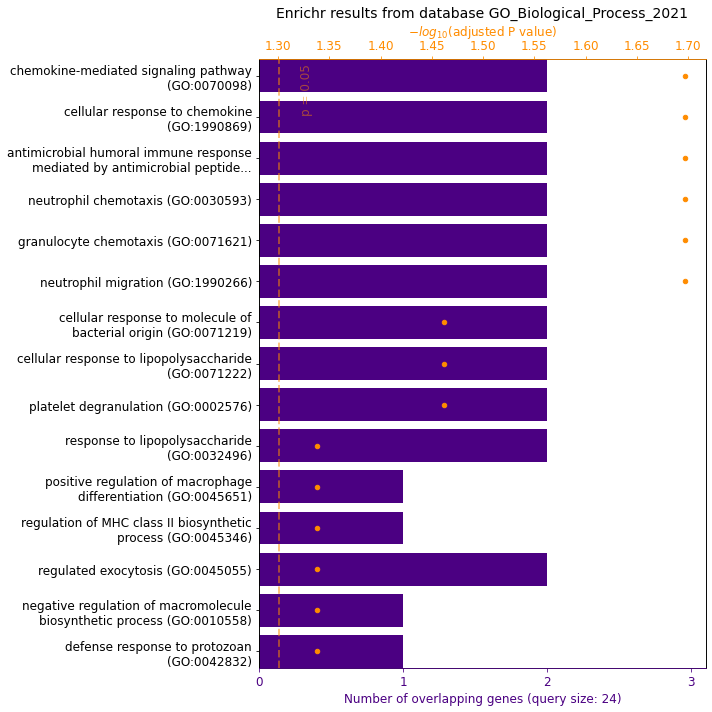

In [52]:
import gget

gget.enrichr(outlier_genes[0].tolist(), ensembl=True, database="ontology", plot=True)

In [37]:
normal_gene_idx = (filled_mean < 0.5*empty_mean) & (empty_mean > 0)
print(normal_gene_idx.sum())

data = empty_droplets[:,normal_gene_idx]
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print(s)

9387
0.46792414105755226


In [38]:
backgroud_total_counts = data.sum(axis=1)

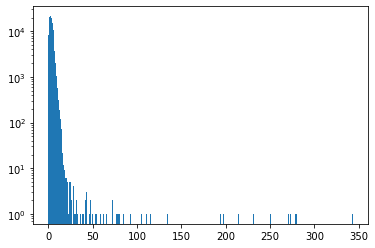

In [39]:
plt.hist(backgroud_total_counts,bins=np.arange(int(np.amax(backgroud_total_counts))+1));
plt.yscale('log')